In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import tqdm
import sys
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, precision_score, recall_score, auc, roc_curve
from tqdm.notebook import tqdm_notebook

import torchvision.models as models
import seaborn as sns
import matplotlib.pyplot as plt

OSError: [WinError 1455] The paging file is too small for this operation to complete. Error loading "C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\torch\lib\cudnn_cnn_train64_8.dll" or one of its dependencies.

In [ ]:
sns.set_theme()
sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.ImageFolder(root="C:/Users/Wxei/fitoBack/White224Balanced/", transform=transform)
train_indices, val_indices = train_test_split(list(range(len(dataset.targets))), test_size=0.2, stratify=dataset.targets)

trainDataset = torch.utils.data.Subset(dataset, train_indices)
testDataset = torch.utils.data.Subset(dataset, val_indices)

In [6]:
from collections import Counter

count = Counter(dataset.targets)
count

Counter({0: 127, 1: 120})

In [7]:
BATCH_SIZE = 512

train_loader = torch.utils.data.DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=6)
test_loader = torch.utils.data.DataLoader(testDataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=6)

cuda = torch.device('cuda')

In [8]:
healthy_count = count[0]
rust_count = count[1]
sum_count = healthy_count + rust_count

class_weights = torch.tensor([sum_count / healthy_count, sum_count / rust_count], dtype=torch.float)
class_weights

tensor([1.9449, 2.0583])

In [17]:
alexnet = models.alexnet(pretrained=False)
alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
alexnet.to(cuda)
model = nn.Sequential(
    alexnet,
    nn.Softmax(dim=1)
).to(cuda)

In [18]:
def convert_relu_to_leaky(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            convert_relu_to_leaky(child)

In [19]:
convert_relu_to_leaky(model)
model

Sequential(
  (0): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): LeakyReLU(negative_slope=0.01)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.01)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): LeakyReLU(negative_slope=0.01)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): LeakyReLU(negative_slope=0.01)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Seq

In [20]:
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(cuda))
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

n_epochs = 20

In [21]:
def train_epoch(model, train_loader, criterion, optimizer, device="cuda:0"):
    model.train()
    train_losses = []
    for imgs, true_labels in train_loader:
        true_labels = true_labels.to(device)
        
        optimizer.zero_grad()
        out = model(imgs.to(device)).squeeze()
        loss = criterion(out, true_labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

In [22]:
def run_test(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        true_labels, pred_labels = [], []
        for imgs, t_true_labels in test_loader:
            pred_labels += np.argmax(model(imgs.to(cuda)).squeeze().cpu(), axis=1).tolist()
            true_labels += t_true_labels.tolist()
    return accuracy_score(pred_labels, true_labels), balanced_accuracy_score(pred_labels, true_labels)

In [23]:
for epoch in range(n_epochs):
    train_epoch(model, train_loader, criterion, optimizer, cuda)
    acc, bacc = run_test(model, test_loader, cuda)
    scheduler.step()
    print(f'raw accuracy: {acc}')
    print(f'balanced accuracy: {bacc}')

C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


raw accuracy: 0.52
balanced accuracy: 0.52


C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


raw accuracy: 0.52
balanced accuracy: 0.52


C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


raw accuracy: 0.52
balanced accuracy: 0.52


C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


raw accuracy: 0.52
balanced accuracy: 0.52


C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


raw accuracy: 0.52
balanced accuracy: 0.52


C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


raw accuracy: 0.52
balanced accuracy: 0.52


C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


raw accuracy: 0.52
balanced accuracy: 0.52


C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


raw accuracy: 0.52
balanced accuracy: 0.52


C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


raw accuracy: 0.52
balanced accuracy: 0.52


C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


raw accuracy: 0.52
balanced accuracy: 0.52


C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


raw accuracy: 0.52
balanced accuracy: 0.52


C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


raw accuracy: 0.52
balanced accuracy: 0.52


C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


raw accuracy: 0.52
balanced accuracy: 0.52


C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


raw accuracy: 0.52
balanced accuracy: 0.52


C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


raw accuracy: 0.52
balanced accuracy: 0.52


C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


raw accuracy: 0.52
balanced accuracy: 0.52


C:\Users\Wxei\anaconda3\envs\fito\lib\site-packages\sklearn\metrics\_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


raw accuracy: 0.52
balanced accuracy: 0.52


KeyboardInterrupt: 

In [14]:
def evaluation(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        true_labels, pred_labels = [], []
        for imgs, t_true_labels in test_loader:
            pred_labels += np.argmax(model(imgs.to(cuda)).squeeze().cpu(), axis=1).tolist()
            true_labels += t_true_labels.tolist()
        acc = accuracy_score(true_labels, pred_labels)
        bacc = balanced_accuracy_score(pred_labels, true_labels)
        pr = precision_score(true_labels, pred_labels, average='weighted')
        recall = recall_score(true_labels, pred_labels, average='weighted')
        print(f'accuracy: {acc}')
        print(f'balanced accuracy: {bacc}')
        print(f'precision: {pr}')
        print(f'recall: {recall}')

        fpr, tpr, thresholds = roc_curve(true_labels, pred_labels, pos_label=1)
        auc_score = auc(fpr, tpr)
        print(f'auc: {auc_score}')
        conf_matrix = confusion_matrix(true_labels, pred_labels)
        heatmap = sns.heatmap(conf_matrix, annot=True, fmt='g')
        heatmap.set(xlabel='Predicted label', ylabel='True label')
        plt.show()

accuracy: 0.82
balanced accuracy: 0.8316912972085386
precision: 0.8346141215106733
recall: 0.82
auc: 0.8237179487179488


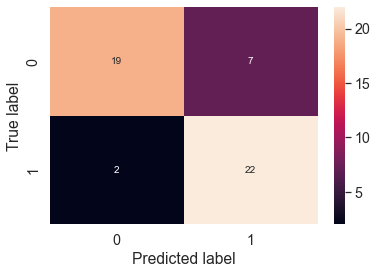

In [15]:
evaluation(model, test_loader, cuda)